**Sammanfattning:**

I den här uppgiften svarar jag på följande frågor och har också med egna analyser. Jag har valt att skriva ut allt på engelska då jag behöver få in engelskan i rutin när jag skriver kod. 

1. Räkna ut medel, median, min och max för: age, weight, height, systolic_bp, cholesterol.
2. Skapa minst 3 olika grafer (t.ex. histogram över blodtryck, boxplot över vikt per kön, stapeldiagram över andelen rökare).
3. 
* a) Beräkna andelen personer i datasetet som har sjukdomen.
* b) Använd numpy för att simulera 1000 slumpade personer med samma sannolikhet för sjukdom.
* c) Jämför den simulerade andelen med den verkliga andelen i datasetet.

4. Beräkna konfidensintervallet med två olika metoder (t.ex. normalapproximation och bootstrap) och jämför resultaten (VG)
5. Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.
6. Gör en simulering för att undersöka hur säkert ditt hypotes­test är (t.ex. hur ofta testet hittar en skillnad när den finns → power). (VG)

**Import and clean data**

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import linalg
import math
from src.moduls import * 
from src.io_utils import *
from src.viz import *
import statsmodels.api as sm

np.random.seed(42)

df = clean_data(read_data("dataset/health_study_dataset.csv"))
df.sample(10)

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
696,697,54,M,179.5,103.7,151.2,5.28,Yes,0
667,668,72,M,172.1,103.4,164.3,5.93,No,0
63,64,32,F,167.0,58.9,129.5,2.81,No,0
533,534,31,M,172.1,55.7,124.8,4.73,No,1
66,67,48,M,185.2,83.0,144.6,5.46,No,1
621,622,57,F,159.0,55.5,162.5,3.72,No,0
346,347,28,M,180.8,88.6,148.1,4.97,No,1
490,491,49,F,171.2,91.1,131.8,6.10,No,0
760,761,41,F,166.2,66.9,142.5,4.48,Yes,0
456,457,48,F,173.5,61.0,140.9,4.66,No,0


**1. Max, min, mean, median of:**
- Age
- Weight
- Height
- Systolic_bp
- Cholesterol


In [2]:
showing_standard_info(df)

,age,weight,height,systolic_bp,cholesterol
Max,90.00000,114.400,200.40000,185.900000,7.88000
Min,18.00000,33.700,144.40000,106.800000,2.50000
Mean,49.42625,73.413,171.84925,149.178625,4.92915
Median,50.00000,73.200,171.35000,149.400000,4.97000


**2. a) Boxplot of weight grouped by sexes**

**Conclusion: Men are heavier than women when comparing:**
- Mean
- Q1 to Q3, where men's interval is higher than women's
- The normalised interval, where the entire interval (excluding outliers) are higher than women
- Funny sidenote, even when looking at the outliers, the low-weight outliers-men are within the women's normal range, and vice versa for the heavier outliers of women, within the normal range of men.

**Motivation of using boxplot for this scenario:** My main motivation is best described from this quoto: *"Boxplots are built to provide high-level information at a glance, offering general information about a group of data’s symmetry, skew, variance, and outliers. It is easy to see where the main bulk of the data is, and make that comparison between different groups."*

They do however have some limitations, but for this purpose in this specific boxplot, we won't get any of these.

- Källa: https://www.atlassian.com/data/charts/box-plot-complete-guide



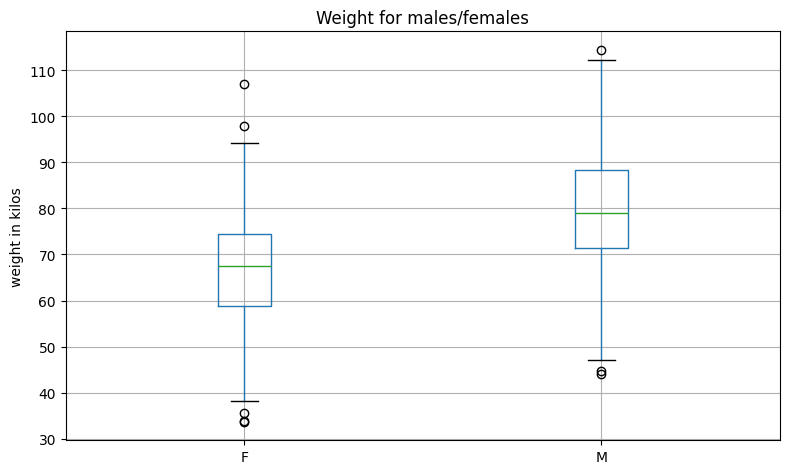

In [3]:
plot_gender_weight_difference(df)

**2. b) Comparing the blood pressure between disease and non-disease people, grouped by sex and smokers**

**Conclusion by only comparing the bars**
- Sick people have, as a group, a higher average bloodpressure than non-sick people in all groups except males who smokes

**Motivation of using barplot:** My choice of barplot is best described with this quote: *"Why Use Bar Plots?
Bar plots are significant because they provide a clear and intuitive way to visualize categorical data. They allow viewers to quickly grasp differences in size or quantity among categories, making them ideal for presenting survey results, sales data, or any discrete variable comparisons."*

And in this case we are comparing different groups (sex and smokers) with the numerical value of systolic bp.

https://www.geeksforgeeks.org/pandas/bar-plot-in-matplotlib/


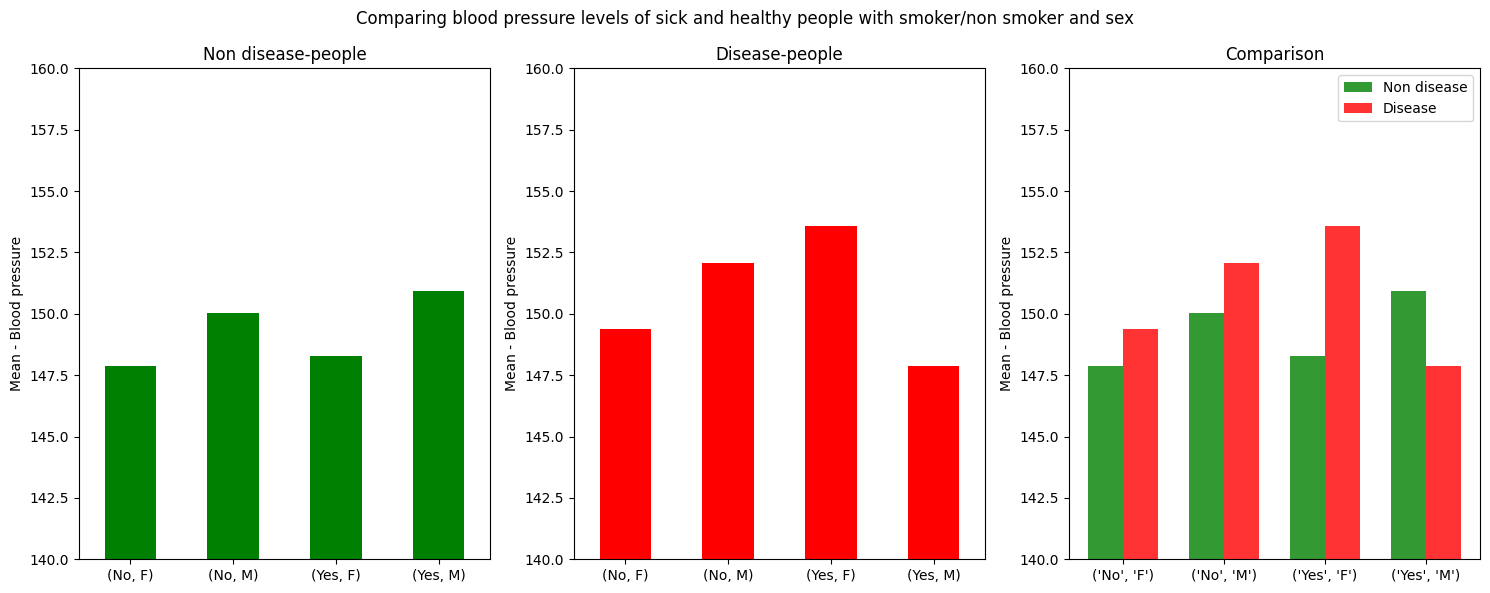

In [4]:
tuple_of_healthy_vs_diseased = healthy_vs_diseased_info(df)
plot_disease_vs_healthy(tuple_of_healthy_vs_diseased[1], tuple_of_healthy_vs_diseased[0])

**2. c) Comparing age with cholesterol between disease and non-disease people**

**Conclusion**
- Too few datapoints from the disease-group to actually tell anything but, but looking at age and cholesterol in it's total it seems like cholesterol raises with age.

**Motivation of using scatter-plot:** Scatter plot is generally the best choice when we have two numerical variables that we want to check against each other's to see if there could be any correlation ( https://online.visual-paradigm.com/knowledge/data-visualization/what-is-scatter-diagram/ ). However, to make things even clearer we can also use linear regression, to make a linear function within our graph that tries to be as close to as many datapoints are possible ( https://www.britannica.com/topic/linear-regression ) which can then be used to make predictions. However, it must be noted that linear regression does not check for any statistical significance, and this is a great example of that, that despite us having only 47 datapoints, it draws the linear function anyway. 

c:\Users\Jakob\Desktop\Github-projekt\Examineringsuppgift\src\viz.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


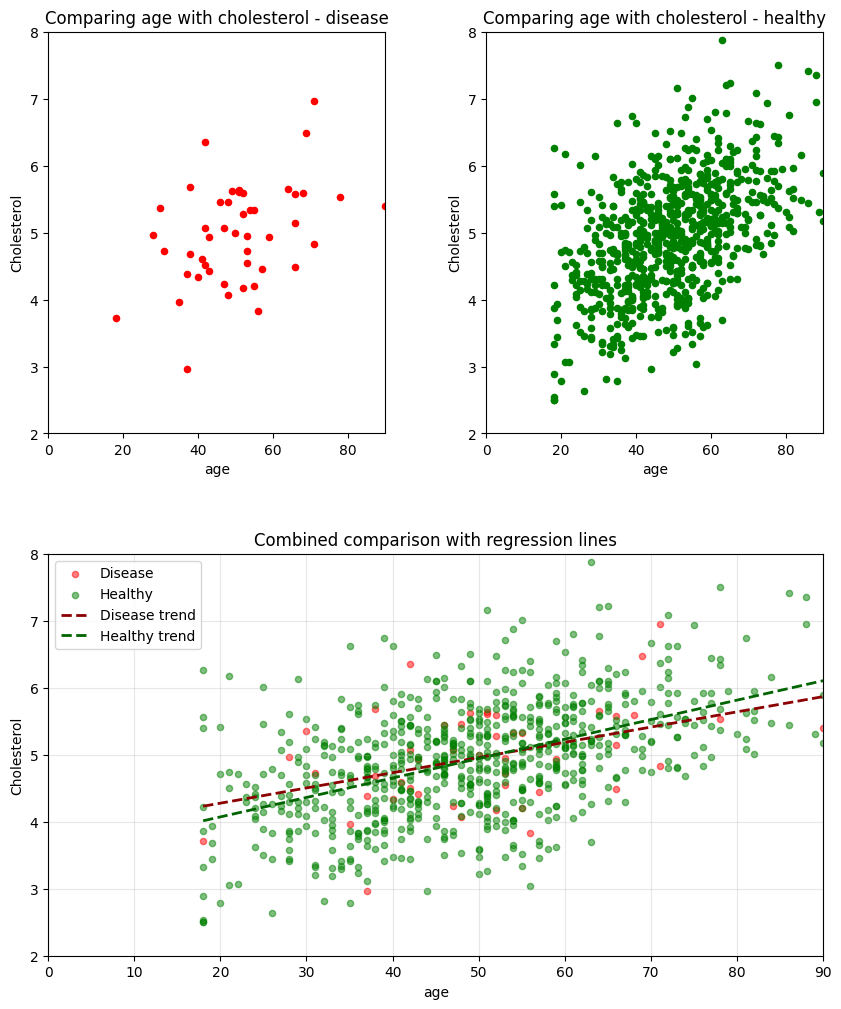

In [5]:
tuple_of_healthy_vs_diseased_mask = healthy_vs_diseased(df)
plot_comparing_age_with_cholesterol(tuple_of_healthy_vs_diseased_mask[0], tuple_of_healthy_vs_diseased_mask[1])

**3. Disease-frequency vs creating a random dataset with the actual disease frequency**

- Blue: Actual disease-frequency
- Yellow: Randomised dataset with the actual frequency in mind
- Red: Difference between the actual and the random frequency

**Motivation of using bar-plot:** Since comparing two categories, one actual and one fictional frequency, we are comparing two groups numerical difference, and that is best plotted with a barplot. See previous motivation from 2 b).

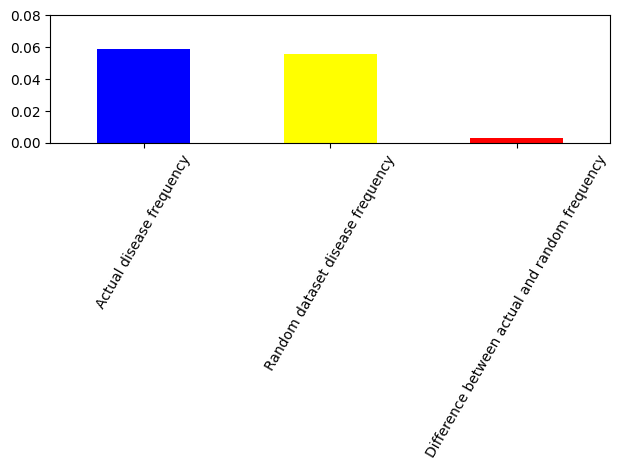

Actual disease frequency                          0.059
Random dataset disease frequency                  0.056
Difference between actual and random frequency    0.003
dtype: float64

In [6]:
df_frequency = actual_frequency_vs_random_generated_frequency(df)
plot_actual_frequency_vs_random_generated_frequency(df_frequency)
df_frequency

**4. CI normal approximation and bootstrap of systolic bp**

**Conclusion**

Both bootstrap and normal approximation shows a very similar result, indicating that normal approximation is in this scenario a robust way of calculating a confidence interval. If the results from the two methods were to differ significantly, it would indicate that the Central Limit Theorem (CLT) is not sufficiently satisfied. Either because our n is too small for the sampling distribution of the mean to be approximated as normal, or because the underlying data distribution is highly non-normal (skewed, heavy-tailed), which the bootstrap method is better equipped to handle.

https://www.youtube.com/watch?v=xjYEYBvPaSc&t=2572s


=== JÄMFÖRELSE AV KONFIDENSINTERVALL ===

                Method  Lower limit  Upper limit        Mean  Interval width
0  Normalapproximation   148.292090    150.06516  149.178625        1.773069
1            Bootstrap   148.307109    150.07415  149.178625        1.767041

=== SKILLNADER MELLAN METODERNA ===
Difference in lower limit: 0.0150
Difference in upper limit: 0.0090
Difference in mean: 0.0000


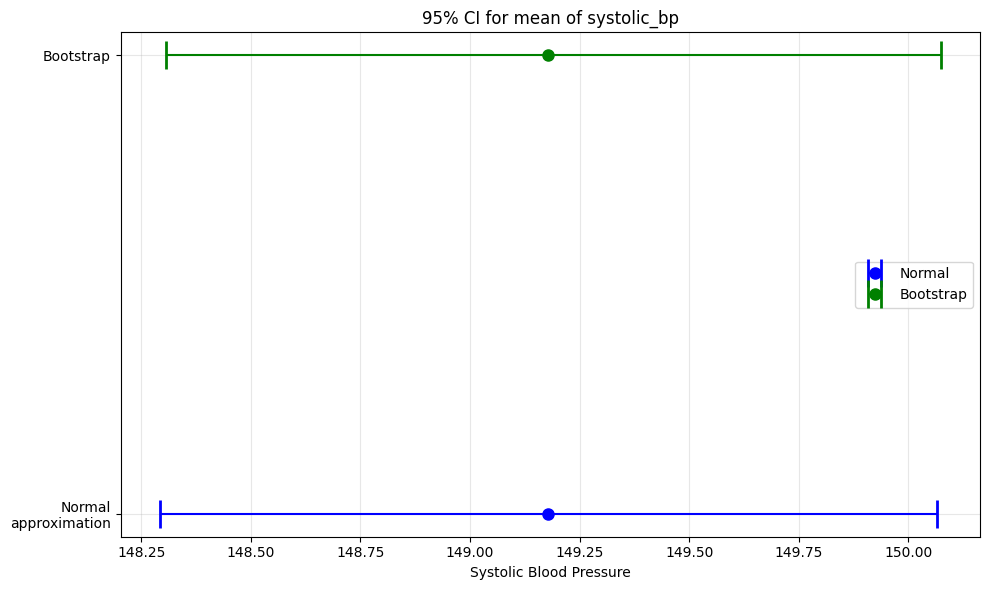

In [7]:
ci_analysis = CI_and_bootstrap(df["systolic_bp"], confidence=0.95)

results = ci_analysis.compare_methods(B=10000)

results

plot_ci_comparison(results)

**Bonus hypothesis-test**: Bloodpressure in healthy vs disease group differs

- *H0: Bloodpressure in healthy and disease-group is the same*
- *H1: Bloodpressure in healthy and disease-group differs*

**Conclusion**

The test didn't find a p-value < 0.05, but rather a p-value > 0.3 which is way too high for a significant result. Therefore, we cannot reject the null hypothesis.

**Motivation of why using a two tail t-test:** We want to find out if there are any markers that could give an indication of a person being sick, and we don't know how the disease affects systolic bp, so therefore we want to first figure out if there is a difference between the disease group and the non disease group at all, and so we use a two tail test t-test to see if the mean of the disease systolic bp is actually, in a statistical significant way, different from that of the healthy group. 

https://statisticsbyjim.com/hypothesis-testing/one-tailed-two-tailed-hypothesis-tests/ <-- Theory
https://www.youtube.com/watch?v=jfBuCNus-HY <-- Code

In [8]:
disease, healthy = healthy_vs_diseased(df)

stats.ttest_ind(a=disease["systolic_bp"],
                b=healthy["systolic_bp"],
                equal_var=False)

TtestResult(statistic=np.float64(0.8541835931340537), pvalue=np.float64(0.39695573395339223), df=np.float64(51.54602842475532))

**Bonus power-test: Checking for how often our t-test will actually find a difference if there is one (type 2 error)**

- Power: 0.177 with difference between sick and healthy set to: 2mmHg
- Power: 0.705 with difference between sick and healthy set to: 5mmHg
- Power: 0.849 with difference between sick and healthy set to: 6mmHg
- Difference set to greater than 6 mmHg generates a power well above 0.85, which is considered a valid number.

**Conclusion:** Our previous t-test will not find small differences between the groups (differences between the group of < 6 mmHg), since our datapoints are too few. However, greater differences between the groups will still be found (> 6 mmHg). If we want our t-test to be more refined for finding even small differences, we need to increase our n greatly.

**Motivation of using power-test:** Since we want to find out what kind of differences our previous t-test will actually be able to find, considering our n, we use a power-test so see how many times our t-test finds significant differences, considering the scenario that there actually is a real difference. This is usually a method you want to use before collecting your sample, since it gives an indication of how large our n needs to be. But since we already have our sample, and our t-test couldn't find a significant difference, we want to see for ourselves how refined our t-test actually was.

https://www.youtube.com/watch?v=fmEk4L9IlA8&t=1s


In [9]:
# print(disease.describe())     #<-- To check if the correct n and std have been plugged in
# print(healthy.describe())     #<-- To check if the correct n and std have been plugged in

print(checking_power_of_that_t_test(47,753,13.172255, 12.771772, 2, 0.05, 1000, "two-sided"))
print(checking_power_of_that_t_test(47,753,13.172255, 12.771772, 5, 0.05, 1000, "two-sided"))
print(checking_power_of_that_t_test(47,753,13.172255, 12.771772, 6, 0.05, 1000, "two-sided"))
print(checking_power_of_that_t_test(47,753,13.172255, 12.771772, 8, 0.05, 1000, "two-sided"))
print(checking_power_of_that_t_test(47,753,13.172255, 12.771772, 10, 0.05, 1000, "two-sided"))


--- Simulation Results ---
Assumed true difference (Effect size): 2 mmHg
Sample sizes: Sick=47, Healthy=753
Significance level (Alpha): 0.05

Number of significant results: 177 of 1000
Calculated power (Power): 0.177


(0.177, 2)
--- Simulation Results ---
Assumed true difference (Effect size): 5 mmHg
Sample sizes: Sick=47, Healthy=753
Significance level (Alpha): 0.05

Number of significant results: 705 of 1000
Calculated power (Power): 0.705


(0.705, 5)
--- Simulation Results ---
Assumed true difference (Effect size): 6 mmHg
Sample sizes: Sick=47, Healthy=753
Significance level (Alpha): 0.05

Number of significant results: 849 of 1000
Calculated power (Power): 0.849


(0.849, 6)
--- Simulation Results ---
Assumed true difference (Effect size): 8 mmHg
Sample sizes: Sick=47, Healthy=753
Significance level (Alpha): 0.05

Number of significant results: 978 of 1000
Calculated power (Power): 0.978


(0.978, 8)
--- Simulation Results ---
Assumed true difference (Effect size): 10 mmHg
Sample

**5. Trying hypothesis smokers have higher systolic bp than non smokers**

- H0: Smokers does not have higher systolic bp than non smokers
- H1: Smokers do have higher systolic bp than non smokers

**Conclusion:** p-value = 0.326, which means that we cannot reject our null hypothesis, and cannot conclude that smokers do have higher systolic bp than non smokers. 

**Motivation:** Here, we only want to check if smokers have a higher systolic bp than non smokers, and we therefore only use a one tail t-test, specifically checking the right side of our normal approximation, while also assuming that the two groups variance can differ from one another (welch test). 
Links: https://statisticsbyjim.com/hypothesis-testing/one-tailed-two-tailed-hypothesis-tests/ <-- Theory
https://www.youtube.com/watch?v=jfBuCNus-HY <-- Code

In [10]:
smokers, non_smokers = looking_for_them_smokers(df)


result = stats.ttest_ind(a=smokers["systolic_bp"],
                        b=non_smokers["systolic_bp"],
                        equal_var=False,
                        alternative="greater")

print(result)

TtestResult(statistic=np.float64(0.4503433193393224), pvalue=np.float64(0.3263669371699499), df=np.float64(360.15254973870043))


**6. Power-testing the previous t-test**

**Conclusion:** Here, in comparison to our previous power test, we can see that we have a sufficient power of finding a the difference that smokers have a higher systolic bp of greater than 3 mmHg. If the difference is less than 3 mmHg, our test wont have sufficient power, and we might miss the difference. 

**Motivation of using a power-test:** As previously stated, since we couldn't find a significant greater mean of systolic bp when comparing smokers to non smokers, and we already have our sample size, it is logical to see how refined our t-test actually was in finding even small differences. Therefore, we do this power-test.

In checking power of that t-test i use a for loop which uses the basics of a t-test, creating some random datasets, doing t-test and viewing if the result came back as significant. However, there is a better method for this i found at https://docs.scipy.org/doc/scipy//reference/generated/scipy.stats.power.html . This does it faster since it doesn't need to loop 1000 times, but since i'm in the beginnig of my statistical journey, my method is easier to follow for a novice. 





In [11]:
# print(smokers.describe())         #<-- To check if the correct n and std have been plugged in
# print(non_smokers.describe())     #<-- To check if the correct n and std have been plugged in

checking_power_of_that_t_test(213, 587, 13.2678 ,12.626038, 2, 0.05, 1000, "greater")
checking_power_of_that_t_test(213, 587, 13.2678 ,12.626038, 3, 0.05, 1000, "greater")

--- Simulation Results ---
Assumed true difference (Effect size): 2 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 616 of 1000
Calculated power (Power): 0.616


--- Simulation Results ---
Assumed true difference (Effect size): 3 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 890 of 1000
Calculated power (Power): 0.890




(0.89, 3)

**Bonus-plot** 

**Notes:** Since having our print in our "checking_power_of_that_t_test" we get some ugly prints when running our plot, since our plot uses the function repeatedly.

**Conclusion:** Here we actually calculate the difference that our t-test will find with a power of 80%, so we find that we will find a difference of 2,5 mmHg.

**Source:** The one and only Joakim -> https://www.youtube.com/watch?v=tAW2Komgulk&t=4164s

--- Simulation Results ---
Assumed true difference (Effect size): 0.0 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 46 of 1000
Calculated power (Power): 0.046


--- Simulation Results ---
Assumed true difference (Effect size): 0.25 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 80 of 1000
Calculated power (Power): 0.080


--- Simulation Results ---
Assumed true difference (Effect size): 0.5 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 124 of 1000
Calculated power (Power): 0.124


--- Simulation Results ---
Assumed true difference (Effect size): 0.75 mmHg
Sample sizes: Sick=213, Healthy=587
Significance level (Alpha): 0.05

Number of significant results: 188 of 1000
Calculated power (Power): 0.188


--- Simulation Results ---
Assumed true difference (Effect size): 1.0 mmHg
Sample sizes: Sick=213, Healthy=587
S

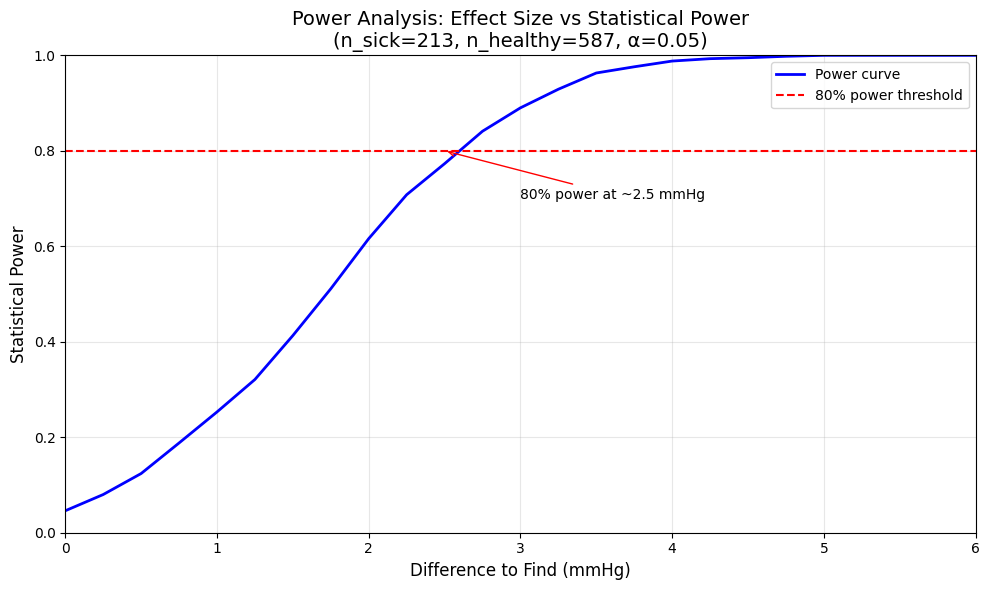


--- Summary ---
Effect size needed for 80% power: ~2.50 mmHg


In [12]:
plotting_power_of_that_t_test(213, 587)